# Land Use and Land Cover Classification with Exploratory Time Series Analysis

This Jupyter Notebook aims to present one way to explore and analysis Land Use and Land Cover (LULC) samples data to evaluate the samples quality to be used in machine learning algorithm. The Sample Assessment App code can be acessed by Github repository: [Sample Assessment App](https://github.com/AbnerErnaniADSFatec/sample-assessment).

## Methodology

This approach aims to demonstrate the use of SOM method implemented by the SITS package in R language combined with the Shiny package for web application development with R language and Jupyter Lab to make available to the user a collaborative environment for efficient analysis of samples as a software solution. The software solutions aim to facilitate access to analysis methods for researchers who do not have specific technical knowledge of information technology such as the application of programming languages and algorithm construction. In this case we are going to use this libs for sample data analysis:

 - [SITS - Satellite Image Time Series](https://github.com/e-sensing/sits): This package provides a set of tools for the analysis, visualization and classification of time series from satellite imagery. The main functionality of the `sits` package is support for the classification of land use and land cover changes in satellite imagery;
 
 - [SITS - Data](https://github.com/e-sensing/sitsdata): This project contains in situ data sets used in the e-sensing project. These data sets consists of time series of selected locations which are used to train the statistical learning models used in the e-sensing studies;
 
 - [dplyr](https://cran.r-project.org/web/packages/dplyr/index.html): is a new package which provides a set of tools for efficiently manipulating datasets in R;
 
 - [ggplot2](https://cran.r-project.org/web/packages/ggplot2/index.html): ggplot2 is a plotting package that makes it simple to create complex plots from data in a data frame;
 
 - [plotly](https://plotly.com/): this package provides online graphing, analytics, and statistics tools for individuals and collaboration, as well as scientific graphing libraries for Python, R, MATLAB, Perl, Julia, Arduino, and REST;
 
 - [stars](https://r-spatial.github.io/stars/): This R package provides classes and methods for reading, manipulating, plotting and writing such data cubes, to the extent that there are proper formats for doing so;
 
 - [leaflet](https://rstudio.github.io/leaflet/shiny.html): The Leaflet package includes powerful and convenient features for integrating with Shiny applications. 

First step is to import all needed libraries for analysis that are listed on [`install-requirements.r`](./utils/R/install-requirements.r) file:

We need to implement a method to facilitate the load of different format files like `.csv`, `.rda` and `.rds`. This method verify the file extension and read the file to retriving the data `tibble`. Now let's import a R file called [`utils`](./utils/R/utils.r) with the methods for convert the tibble data in a shapefile using the latitude and longitude attributes, soon this data will be described.

> Obs.: Whereas you walk step by step from [README.md](./README.md) or install by your own.

In [2]:
source("./utils/R/utils.r")

## Loading data

The example data used here are from sitsdata repository. The repository data description about data format is: All data sets in the "data" directory are tibbles with satellite image time series, with the following columns:

 - **Longitude**: East-west coordinate of the time series sample in WGS 84;
 - **latitude**: North-south coordinate of the time series sample in WGS 84;
 - **Start Date**: initial date of the time series;
 - **End date**: final date of the time series;
 - **Label**: the class label associated to the sample;
 - **Cube**: the name of the image data cube associated with the data;
 - **Time Series**: list containing a tibble with the values of the time series.
 
The data to be used will be based mainly on:

 - **LULC samples**: land use and land cover classes based on geographic coordinates having metadata such as the spectrometer and period the classes were identified;

 - **Time series**: data collected from the stack of remote sensing images containing the value of the spectral bands through time units associated with a single geographic coordinate.

We are going to load a Land Use and Land Cover samples data about Southwest Amazon in Brazil localized in the State of Rondonia in [Region of Interest - ROI](./data/shapes/region_of_interest.json). This case study is due to the increase of land use change in this area:

<p align = "center" style = "width: 60%;">
  <img src = "./data/img/roi_rondonia_amazonia.png">
</p>

> Obs.: This data contains only the samples metadata without time series.

In [3]:
filename <- "./data/samples/samples_amazonia.csv"
input_data.tb <- read_file(filename, "csv")
head(input_data.tb, 5)

,id,longitude,latitude,start_date,end_date,label
,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,1,-64.69448,-9.986312,2018-07-12,2019-07-28,Deforestation
2,2,-64.62979,-9.996668,2018-07-12,2019-07-28,Deforestation
3,3,-64.52163,-9.979772,2018-07-12,2019-07-28,Deforestation
4,4,-64.52049,-10.003682,2018-07-12,2019-07-28,Deforestation
5,5,-64.70766,-10.061506,2018-07-12,2019-07-28,Deforestation


The code below group the labels of all data set, count and after it calculates the percentage using `dplyr` methods:

In [4]:
group <- dplyr::group_by(input_data.tb, label)
agregation <- dplyr::summarise(group, n = n(), .groups = "drop_last")
mutation <- dplyr::mutate(
    agregation,
    percent = n/sum(n),
    color = c("#ff0000", "#005500", "#0fc80f", "#ff8828")
)
mutation <- data.frame(mutation)
mutation <- mutation[order(mutation$percent, decreasing = TRUE),]
mutation

,label,n,percent,color
,<chr>,<int>,<dbl>,<chr>
4,Pasture,460,0.3826955,#ff8828
2,Forest,414,0.3444260,#005500
3,NatNonForest,171,0.1422629,#0fc80f
1,Deforestation,157,0.1306156,#ff0000


We can explore the data and your class labels by creating a pie chart visualization to understand the land coverage:

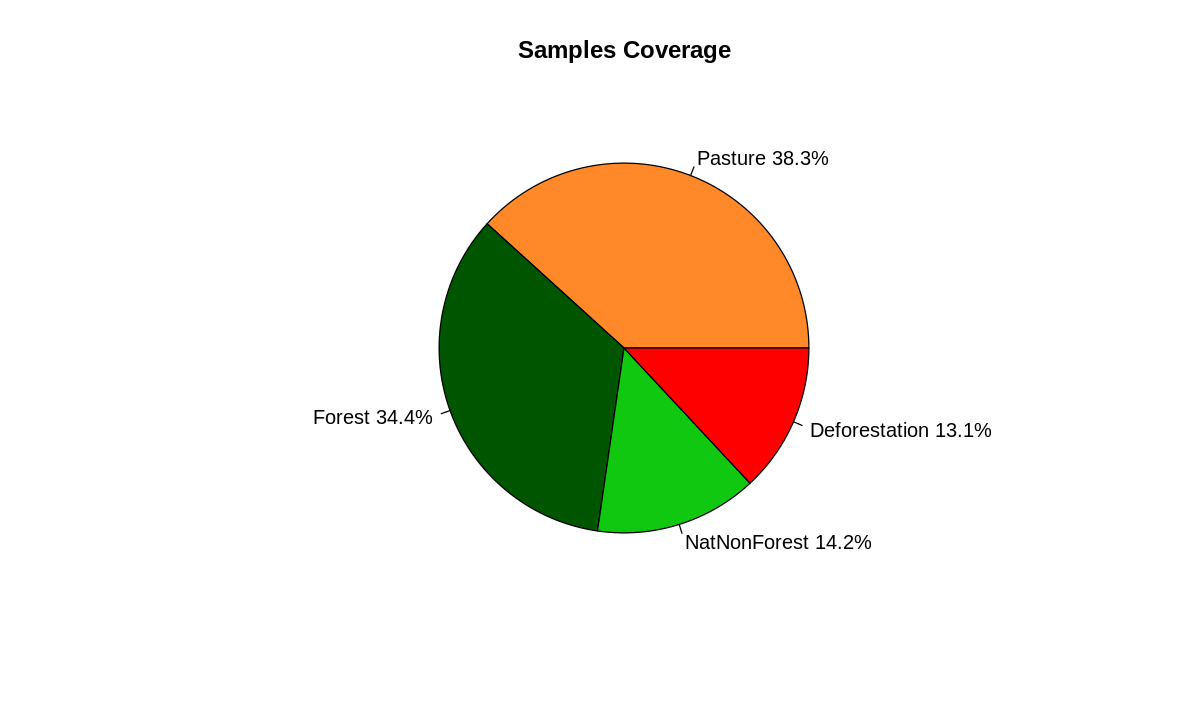

In [5]:
options(repr.plot.width = 10, repr.plot.height = 6)
pie(
    mutation$percent,
    paste(mutation$label, " ", round(mutation$percent * 100, 1), "%", sep=""),
    col=mutation$color,
    main="Samples Coverage"
)

Now we can view this samples on map based on latitude and longitude from data set and fillter by label `Pasture` about 1019 January 01.

We are using `leaflet` package to set a map view with markers:

In [12]:
shape <- point_to_shape_sp(
    data.tb = input_data.tb,
    date = "2019-01-01",
    class_label = "Pasture"
)
leaflet(shape, options = leafletOptions(minZoom = 0, maxZoom = 100)) %>%
        addTiles() %>%
            addMarkers(
                ~longitude, ~latitude,
                popup = ~as.character(
                    paste("Class '", label, "' |",
                        format(
                            as.Date(start_date),
                            format = "Start %Y-%m-%d"
                        ),
                        format(
                            as.Date(end_date),
                            format = "End %Y-%m-%d"
                        )
                    )))

> Obs.: The code above will generate a map output that is not visible on github:
> <p align = "center">
  <img src = "./data/img/leaflet_output_label.png">
</p>

## Getting Time Series

With the classified geometries, the time series extraction process is based on the WTSS service, where two columns are added, one referring to the collection that provides the time series and the data of the collected spectral bands.

With the two extra columns it is possible to identify the spatiotemporal patterns in the samples [3].

We will explore two ways to get time series from images provided by remote sensing.

The first way is by `SITS` package. In this way we need to download the images from data provider and read then using `sits cube` to create a local data cube.

The second way is by `WTSS` service and client developed and distributed by Brazil Data Cube. In this way we only need to fill the parameters required like area of interest and the period and get the response, this way takes longer because is a HTTP request and depends on internet.

### SITS

The package [`SITS - Satellite Image Time Series`](https://github.com/e-sensing/sits) Analysis for Earth Observation Data Cubes provides a set of tools for series analysis, classification and classification from satellite images.

The main functionality of the `sits` package is support for classification of land use and land cover changes in satellite images.

The `sits` Workflow:

   - Creation of a data cube using image collections from cloud or local services;
   - Extraction of time series;
   - Analysis and evaluation of his;
   - Machine learning algorithms training;
   - Classification of a data cube using the machine learning model;
   - Post processing of images;
   - Evaluation of the accuracy generated by the model using best practices;

To create a local data cube we need to fill a simple form with required parameters.

Creating a local data cube by region of interest using Sentinel-2 images downloaded using [EO Cube Python Package](https://github.com/AbnerErnaniADSFatec/eocubes).

To download the required data raster files check the method in [Jupyter Notebook to Image Processing](./ImageProcessingSER413TrabalhoFinalAbnerAnjos.ipynb).

After download (~1h30m) we can create our local data cube:

downsample set to c(28)


[1] "2018-07-28" "2018-08-13" "2018-08-29" "2018-09-14" "2018-09-30"
 [6] "2018-10-16" "2018-11-01" "2018-11-17" "2018-12-03" "2018-12-19"
[11] "2019-01-01" "2019-01-17" "2019-02-02" "2019-02-18" "2019-03-06"
[16] "2019-03-22" "2019-04-07" "2019-04-23" "2019-05-09" "2019-05-25"
[21] "2019-06-10" "2019-06-26" "2019-07-12" "2019-07-28"

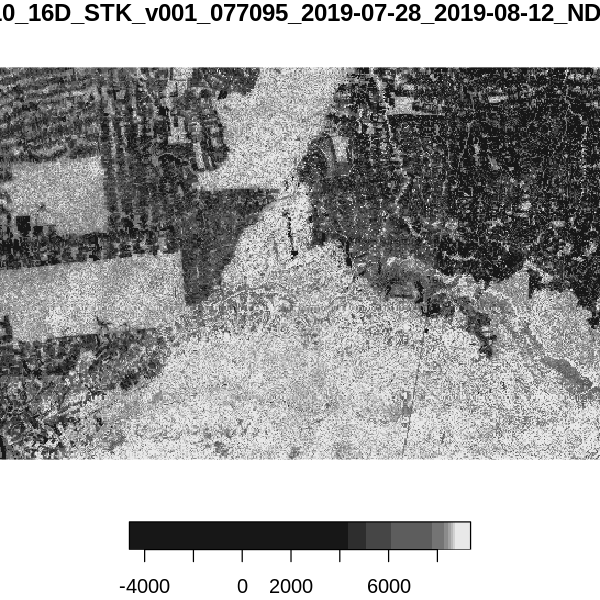

In [8]:
sentinel_cube <- sits_cube(
    source = "LOCAL",
    name = "sentinel-077095",
    satellite = "SENTINEL-2",
    sensor = "MSI",
    resolution = "10m",
    data_dir = "./data/raster/Sentinel-2/077095",
    parse_info = c("X1", "X2", "X3", "X4", "X5", "tile", "date", "X6", "band")
)
options(repr.plot.width = 5, repr.plot.height = 5)
plot(sentinel_cube, band = "NDVI", time = 24)
sits_timeline(sentinel_cube)

With the `sits` package we can load the data set `.csv` and get the time series by the data cube created before using the `sits_get_data` method:

> Obs.: A data set in sits format will be returned with time series coupled with labels and coordinates:

In [ ]:
points <- sits_get_data(sentinel_cube, file = filename)
head(points, 1)

A sample of time series returned from this operation can be visualized below:

In [ ]:
head(tibble(points$time_series[[1]]), 3)

And now we can view the data in line chart using plot:

> **Note**: The bands shown in chart are provided by the filename of downloaded images like "EVI" and "NDVI" suffix.

In [ ]:
options(repr.plot.width = 15, repr.plot.height = 6)
filtered <- dplyr::filter(points, label == "Pasture")
plot(filtered)

In [ ]:
save_file(points, "samples_amazonia", "rda")

### WTSS

_"The Rwtss package is a front-end to the Web Time Series Service (WTSS) that offers time series of remote sensing data using a simple API. A WTSS server takes as input an Earth observation data cube, that has a spatial and a temporal dimension and can be multidimensional in terms of its attributes. The WTSS API has three commands, which are are (a) list_coverages, that returns a list of coverages available in the server; (b) describe_coverage, that that returns the metadata for a given coverage; (c) time_series, that returns a time series for a spatio-temporal location."_

This description is provided by [`R wtss Package`](https://github.com/e-sensing/Rwtss) repository.

To retrieve time series data from the WTSS Service, we need to fill in parameters such as coordinates and period, this parameters we can get from dataset.

We will select an sample randomly and get the time series data by its parameters:

In [ ]:
wtss_inpe <- "https://brazildatacube.dpi.inpe.br/wtss/" # the server for wtss
coverage <- "MOD13Q1-6" # The selected coverage or cube
sample <- data.frame(head(input_data.tb, 1))
start <- sample$start_date
end <- sample$end_date
lat <- sample$latitude
long <- sample$longitude
bands <- c('NDVI', 'EVI', 'NIR_reflectance') # The selected bands

response = Rwtss::time_series(
    wtss_inpe, 
    name = coverage, 
    attributes = bands, 
    longitude = long,
    latitude  = lat,
    start_date = start, 
    end_date = end,
    token = "a6gB61oddyHxMAZ08y098ynEq0s1hQ3siDZao245CV"
)
cube <- response$cube
ts <- data.frame(response$time_series)
head(ts, 3)

Now we can view the data response by plot:

In [ ]:
options(repr.plot.width = 15, repr.plot.height = 6)
plot(response)

### Sample Assessment

In [13]:
input_data.tb <- read_file("./data/samples/samples_amazonia.rda", "rda")
sits_labels_summary(input_data.tb)

label,count,prop
<chr>,<int>,<dbl>
Deforestation,157,0.1306156
Forest,414,0.3444260
NatNonForest,171,0.1422629
Pasture,460,0.3826955


In [50]:
data.tb <- input_data.tb

### Random Forest Classification

In [291]:
data_ml.tb <- data.frame()

for (i in 1:length(data.tb[[1]])) {  
    label <- data.tb[i, ]$label
    time_series <- as.data.frame(data.tb[i, ]$time_series)
    time_line <- dplyr::select(time_series, Index)$Index
    time_series <- dplyr::select(time_series, -Index)
    ts_bands <- names(time_series)
    column_names <- c()
    values <- c()
    
    for (j in 1:length(ts_bands)) {
        ids <- append(ids, id)
        b <- ts_bands[j]
        ts <- c(time_series[b])[[1]]
        column_names <- append(column_names, "label")
        values <- append(values, label)
        column_names <- append(column_names, paste(b, "_sum", sep=""))
        values <- append(values, sum(ts))
        column_names <- append(column_names, paste(b, "_sd", sep=""))
        values <- append(values, sd(ts))
        column_names <- append(column_names, paste(b, "_var", sep=""))
        values <- append(values, var(ts))
        column_names <- append(column_names, paste(b, "_mean", sep=""))
        values <- append(values, mean(ts))
        column_names <- append(column_names, paste(b, "_mode", sep=""))
        values <- append(values, getMode(ts))
        column_names <- append(column_names, paste(b, "_range", sep=""))
        values <- append(values, getRange(ts))
        column_names <- append(column_names, paste(b, "_skewness", sep=""))
        values <- append(values, skewness(ts))
        column_names <- append(column_names, paste(b, "_kurtosis", sep=""))
        values <- append(values, kurtosis(ts))
    }
    data_ml.tb <- rbind(data_ml.tb, values)
}
colnames(data_ml.tb) <- column_names
head(data_ml.tb, 3)

,label,B04_sum,B04_sd,B04_var,B04_mean,B04_mode,B04_range,B04_skewness,B04_kurtosis,label.1,⋯,EVI_kurtosis,label,NDVI_sum,NDVI_sd,NDVI_var,NDVI_mean,NDVI_mode,NDVI_range,NDVI_skewness,NDVI_kurtosis
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,Deforestation,3.0009,0.137310675355803,0.0188542215666667,0.120036,0.0248,0.4594,1.68308774064491,1.30849965822274,Deforestation,⋯,-0.572638093833393,Deforestation,14.1159,0.241008941535371,0.0580853099,0.564636,0.8414,0.7576,-0.546654287140329,-0.888419214511872
2,Deforestation,3.6855,0.180873599971546,0.0327152591666667,0.14742,0.017,0.7329,2.05215701765073,3.49994084296461,Deforestation,⋯,-1.21786261790132,Deforestation,12.1022,0.251602112007564,0.0633036227666667,0.484088,0.884,0.8641,-0.0794743340408551,-1.25415318878195
3,Deforestation,3.443,0.202443201911055,0.04098325,0.13772,0.066,0.7122,2.04188802193272,2.93342602191924,Deforestation,⋯,0.0828476291351965,Deforestation,15.0316,0.269545186193336,0.0726546074,0.601264,0.8648,0.8571,-0.900638144014136,-0.397437223984833


In [292]:
test_data <- dplyr::select(data_ml.tb[601:1202,], -label)
test_labels <- dplyr::select(data_ml.tb[601:1202,], names(data_ml.tb)[1])
data_ml.tb <- data_ml.tb[1:600,]

length(test_labels$label)

[1] 602

In [ ]:
ft_tree <- rpart::rpart(
    formula = label ~ .,
    data = data_ml.tb,
    method = "class",
    control = rpart.control(maxdepth = 10)
)
ft_tree

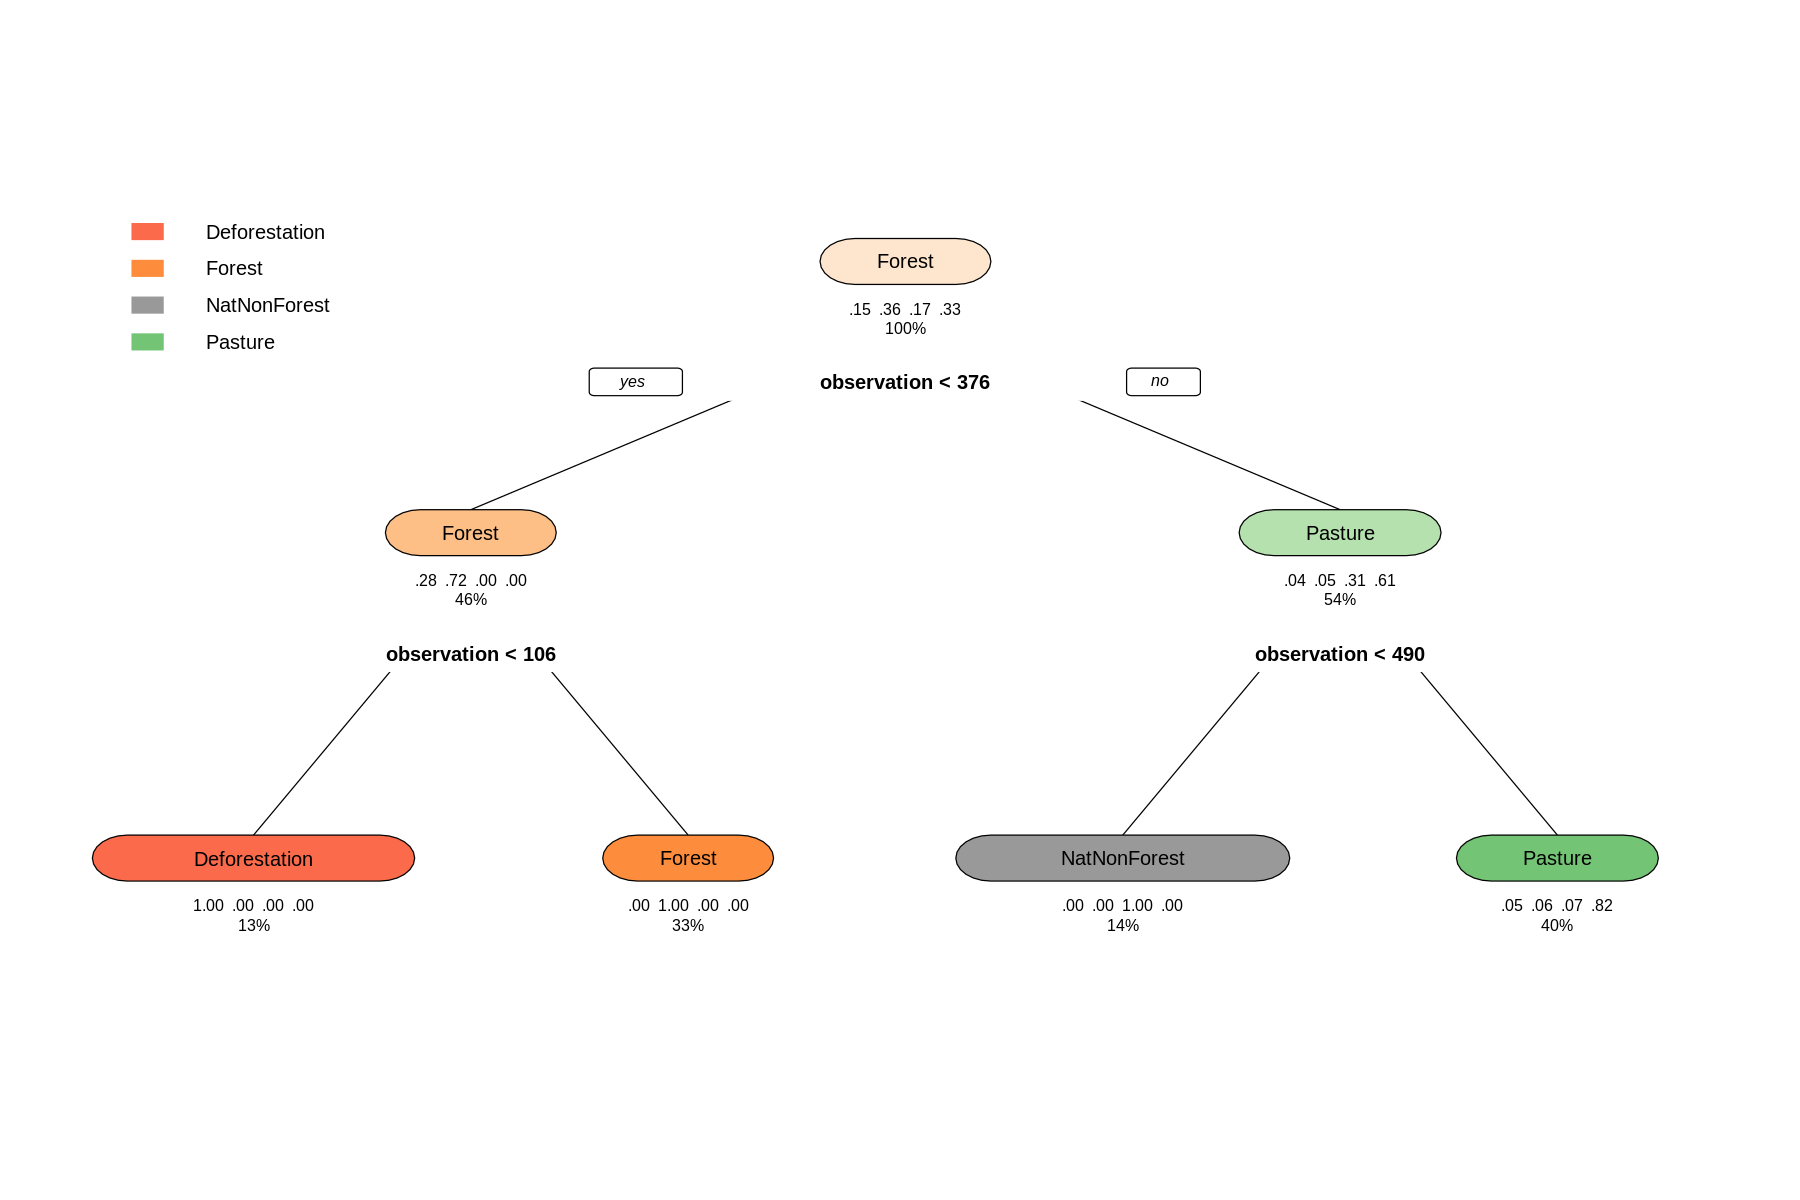

In [149]:
options(repr.plot.width=15, repr.plot.height=10)
rpart.plot::rpart.plot(ft_tree, clip.right.labs = FALSE, branch = .3, under = TRUE)

In [150]:
predict_dt <- predict(ft_tree, test_data, type = "class")
head(predict_dt, 4)

327201  327301  327401  327501 
Pasture Pasture Pasture Pasture 
Levels: Deforestation Forest NatNonForest Pasture

In [151]:
# Criação da matriz de confusão
cm_tree <- caret::confusionMatrix(data = predict_dt, reference = as.factor(test_labels$label))
cm_tree

Confusion Matrix and Statistics

               Reference
Prediction      Deforestation Forest NatNonForest Pasture
  Deforestation             0      0            0       0
  Forest                    0      0            0       0
  NatNonForest              0      0            0       0
  Pasture                 144    492          140     761

Overall Statistics
                                          
               Accuracy : 0.4951          
                 95% CI : (0.4698, 0.5204)
    No Information Rate : 0.4951          
    P-Value [Acc > NIR] : 0.5101          
                                          
                  Kappa : 0               
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: Deforestation Class: Forest Class: NatNonForest
Sensitivity                       0.00000        0.0000             0.00000
Specificity                       1.00000        1.0000             1.

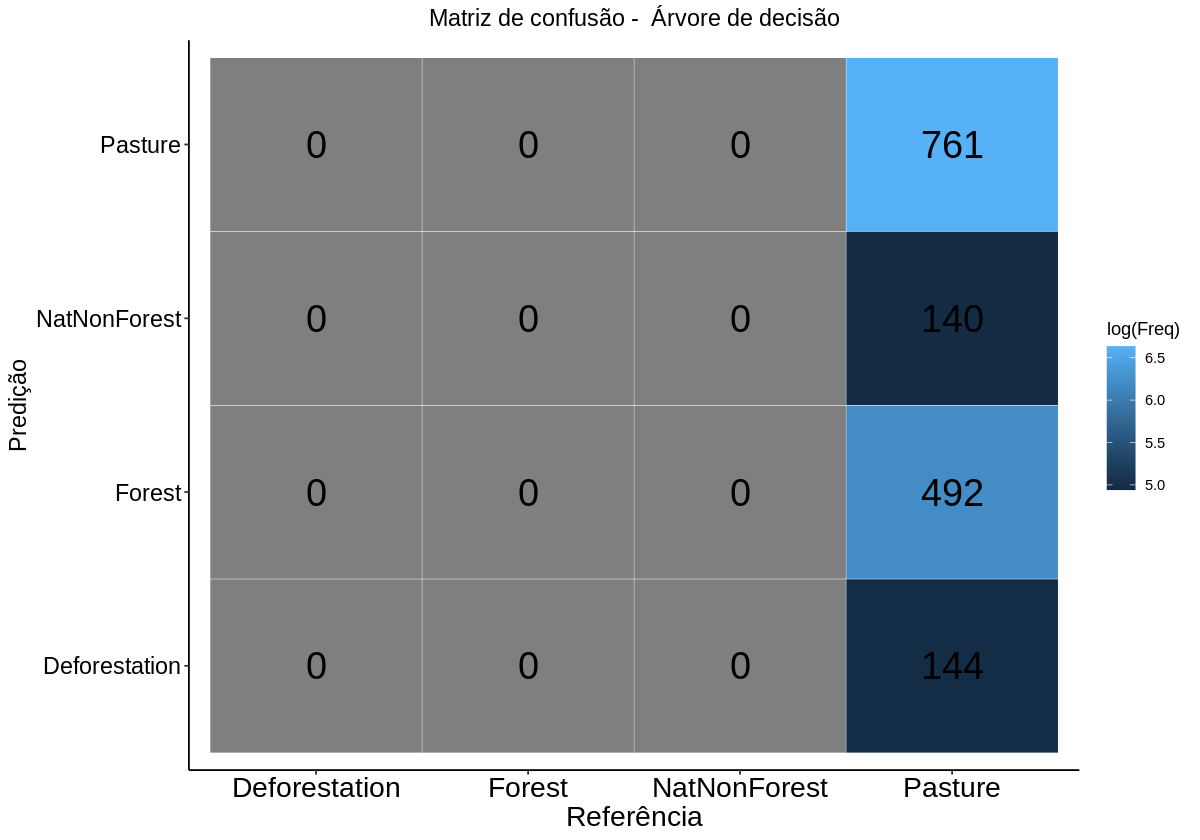

In [152]:
options(repr.plot.width=10, repr.plot.height=7)
cm_plot(cm_tree, model_type = "Árvore de decisão")

In [153]:
summary(data_ml.tb)

test_data.ml <- dplyr::select(test_data, -bands)
test_data.ml <- dplyr::mutate(test_data.ml, bands = as.factor(test_data$bands), .before = 1)
ml <- dplyr::select(data_ml.tb, -label, -bands)
ml <- dplyr::mutate(ml, labels = as.factor(data_ml.tb$label), bands = as.factor(data_ml.tb$bands), .before = 1)
head(ml, 3)

    label            observation       bands                sum         
 Length:3271        Min.   :  1.0   Length:3271        Min.   : 0.5674  
 Class :character   1st Qu.:205.0   Class :character   1st Qu.: 5.2768  
 Mode  :character   Median :409.0   Mode  :character   Median : 9.4296  
                    Mean   :409.4                      Mean   : 9.7872  
                    3rd Qu.:614.0                      3rd Qu.:13.5704  
                    Max.   :818.0                      Max.   :21.7969  
       sd               var                 mean             mode       
 Min.   :0.01031   Min.   :0.0001064   Min.   :0.0227   Min.   :0.0106  
 1st Qu.:0.11754   1st Qu.:0.0138165   1st Qu.:0.2111   1st Qu.:0.1479  
 Median :0.15188   Median :0.0230670   Median :0.3772   Median :0.3035  
 Mean   :0.16488   Mean   :0.0311231   Mean   :0.3915   Mean   :0.3727  
 3rd Qu.:0.20589   3rd Qu.:0.0423900   3rd Qu.:0.5428   3rd Qu.:0.5512  
 Max.   :0.36096   Max.   :0.1302947   Max.   :0.87

,labels,bands,observation,sum,sd,var,mean,mode,range
,<fct>,<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
101,Deforestation,NDVI,1,3.0009,0.1373107,0.01885422,0.120036,0.0248,0.4594
201,Deforestation,EVI,1,7.4910,0.1101241,0.01212731,0.299640,0.2646,0.4195
301,Deforestation,B08,1,10.9120,0.1269910,0.01612670,0.436480,0.5138,0.4989


In [154]:
rf <- randomForest(labels~., data=ml, proximity=TRUE)
rf


Call:
 randomForest(formula = labels ~ ., data = ml, proximity = TRUE) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 2

        OOB estimate of  error rate: 5.72%
Confusion matrix:
              Deforestation Forest NatNonForest Pasture class.error
Deforestation           443     15            8      18  0.08471074
Forest                    8   1111           19      26  0.04553265
NatNonForest              3     18          493      30  0.09375000
Pasture                  11     14           17    1037  0.03892493

In [155]:
prediction.rf <- predict(rf, test_data.ml)

In [156]:
cm_tree <- confusionMatrix(prediction.rf, as.factor(test_labels$label))
cm_tree

Confusion Matrix and Statistics

               Reference
Prediction      Deforestation Forest NatNonForest Pasture
  Deforestation            38     52            6      17
  Forest                   25    206           36      31
  NatNonForest             11     82           32      23
  Pasture                  70    152           66     690

Overall Statistics
                                          
               Accuracy : 0.6285          
                 95% CI : (0.6038, 0.6527)
    No Information Rate : 0.4951          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.3882          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       

Statistics by Class:

                     Class: Deforestation Class: Forest Class: NatNonForest
Sensitivity                       0.26389        0.4187             0.22857
Specificity                       0.94616        0.9120             0.

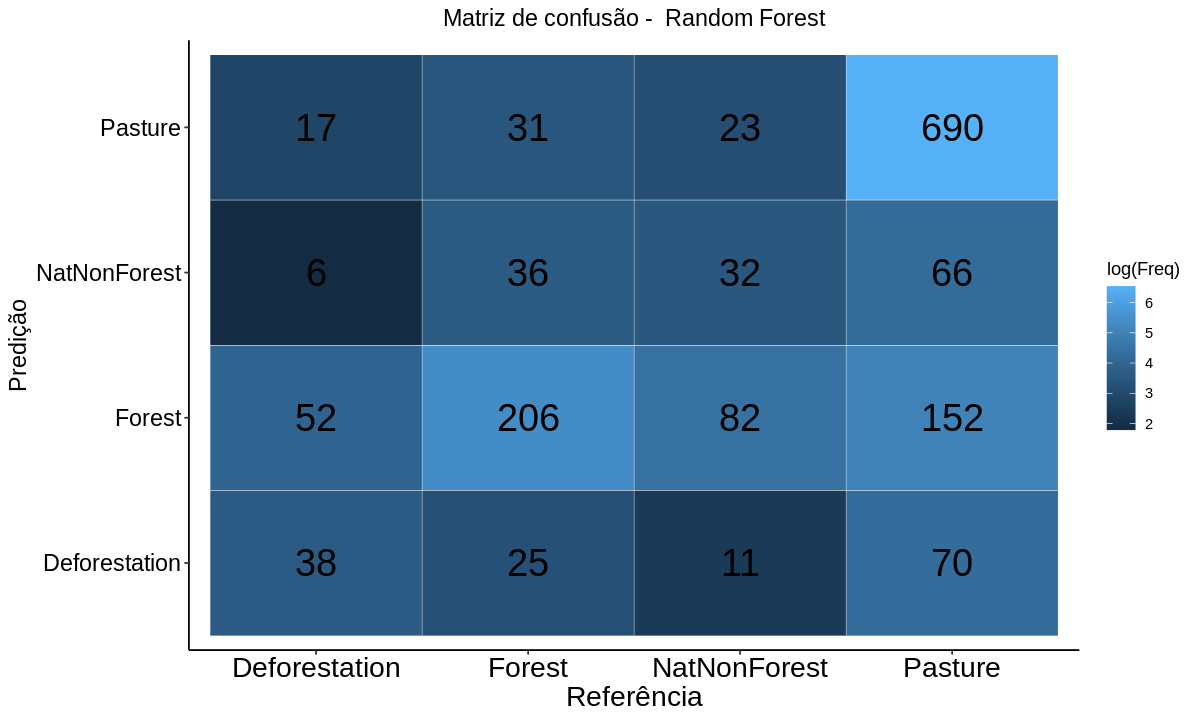

In [157]:
options(repr.plot.width=10, repr.plot.height=6)
plot_rf <- cm_plot(cm_tree, model_type = "Random Forest")
plot_rf

## Final comments

As a result, it is expected to develop a case study about the environment for an exploratory analysis of UCT combined with time series collected from remote sensing images to present attributes that demonstrate the calculation of accuracy and quality of classified maps. It also seeks to develop software solutions for the dissemination of these methods to a scientific community that does not master information technology techniques.

## References

 - [1] Lorena A. Santos, Karine R. Ferreira, Gilberto Camara, Michelle C. A. Picoli, and Rolf E. Simoes. Quality control and class noise reduction of satellite image time series. ISPRS Journal of Photogrammetry and Remote Sensing, 177:75–88, 2021. 

 - [2] Rwanga, S.S. and Ndambuki, J.M. (2017) Accuracy Assessment of Land Use/Land Cover Classification Using Remote Sensing and GIS. International Journal of Geosciences, 8, 611-622. 

 - [3] Lorena Alves Santos, Karine Ferreira, Michelle Picoli, Gilberto Camara, Raul Zurita-Milla, and Ellen-Wien Augustijn. Identifying spatiotemporal patterns in land use and cover samples from satellite image time series. MDPI - Remote Sensing, 13(5):974, 2021